`@author`: Sajal, Rohan, Shubhangkar
`@date`: 04/29/19

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

/ccs/home/sajaldash/summit/tensorflow-1.12-p3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Files

1. Data is split up into batches... e.g `batch_*h5`.  
2. The file names are labeled according to their data partition... e.g. `batch_train*` belongs to training data.
3. `dev` and `test` are for development and testing, respectively.
4. __The data is not shuffled!__

In [2]:
f = h5py.File('../data/train/batch_train_223.h5', mode='r', swmr=True)

Each particular data sample is stored in a separate `h5group`.  
Here are the names of the samples (i.e. groups) in the file.

In [3]:
keys = list(f.keys())
keys

['sample_0_0',
 'sample_0_1',
 'sample_0_2',
 'sample_0_3',
 'sample_0_4',
 'sample_0_5',
 'sample_0_6',
 'sample_0_7',
 'sample_0_8',
 'sample_0_9',
 'sample_1_0',
 'sample_1_1',
 'sample_1_2',
 'sample_1_3',
 'sample_1_4',
 'sample_1_5',
 'sample_1_6',
 'sample_1_7',
 'sample_1_8',
 'sample_1_9',
 'sample_2_0',
 'sample_2_1']

## Data Attributes  
With each `sample` is associated different attributes.

In [4]:
idx = np.random.randint(0, len(list(f.keys())))
key = keys[idx]
group = f[key]
list(group.attrs.items())

[('space_group', b'123'),
 ('material', b'mp-1001605'),
 ('energy_keV', 190),
 ('z_dirs', array([[[1, 1, 2],
          [0, 1, 1],
          [1, 0, 1]]])),
 ('formula', 'Pr1 Bi1'),
 ('y_dirs', array([[[-0.00000000e+000, -0.00000000e+000,  1.00000000e+000],
          [-0.00000000e+000, -6.66666668e-001,  4.74303020e-322],
          [ 2.12244910e-314,  5.18073284e-318,  1.14623230e-321]]],
        dtype=float128)),
 ('semi_angles_rad',
  array([3.42843672e-003, 5.52013561e-003, 1.73850277e-310], dtype=float128)),
 ('d_hkls_angstrom',
  array([2.69908227, 1.67634156, 0.00997325], dtype=float128)),
 ('abc_angstrom',
  array([4.27775390e+000, 3.47901862e+000, 1.69759663e-313], dtype=float128)),
 ('angles_degree',
  array([9.00000000e+001, 9.00000000e+001, 1.69759663e-313], dtype=float128))]

1. `material` is the material name (solids) as cataloged in the materials project https://materialsproject.org/ 
2. `energy_keV` is the electron beam energy (in keV).
3. `z_dir` are the crystallographic (hkl) normal directions of the material from which CBED was acquired.
4. `y_dir` are the crystallographic (hkl) transverse directions of the material from which CBED was acquired.
5. `semi_angles_rad` are the half-angles of convergence of the incident electron beam (in radians).
6. `d_hkls_angstrom` are the d-spacing of the Bragg reflections from which CBED was acquired (in Å).
7. `abc_angstrom` are the lattice constants $(a,b,c)$ of the material (in Å).
8. `angles_degree` are the lattice angles $(\alpha, \beta, \gamma)$ of the material (in degrees).
9. `chemical formula` is the chemical formula of the material.

__And__ 
0. `space_group` __is the space group number (1 - 230) as specified by the conventions of crystallography__. see https://en.wikipedia.org/wiki/List_of_space_groups

In addition to the classification task of the space group `0`, the following attributes can be used as labels in a multi-task ML algorithm: `2`, `6`, `7`, `8`, and `9`.

## Data
The data for each sample is saved as `h5dataset`, with name `cbed_stack`, with dimensions of (3,512,512).  
The first axis contains the 3 different crystallographic directions or material orientations (corresponding to `z_dirs` and `y_dirs`).  
The 2nd and 3rd axis are the diffraction intensities (in reciprocal space).

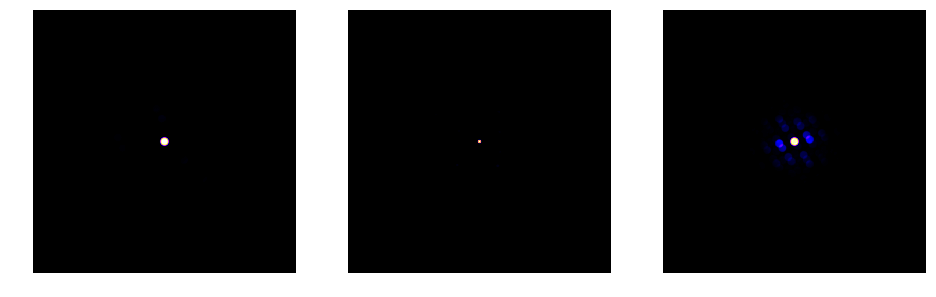

In [5]:
idx = np.random.randint(0, len(list(f.keys())))
key = keys[idx]
group = f[key]
list(group.items())
cbed_stack = group['cbed_stack'][()]
list(group.attrs.items())
fig, axes = plt.subplots(1,3, figsize=(16,12))
for ax, cbed in zip(axes.flatten(), cbed_stack):
    ax.imshow(cbed, cmap='gnuplot2')
    ax.axis('off')

### Note  
CBED data will always have orders of magnitude intensity change from the center of the image.  
As such __proper scaling__ should always be applied. The appropriate scaling function is up to you. Below is $^{1/4}$ scaling.


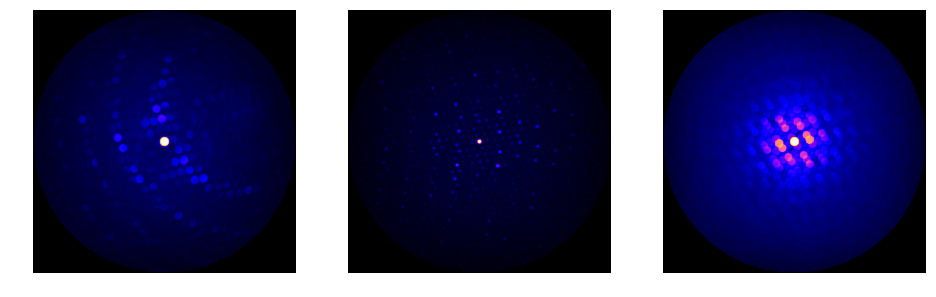

In [6]:
fig, axes = plt.subplots(1,3, figsize=(16,12))
for ax, cbed in zip(axes.flatten(), cbed_stack):
    ax.imshow(cbed**0.25, cmap='gnuplot2')
    ax.axis('off')
plt.show()

In [7]:
def data_from_file(filename):
    f = h5py.File(filename, mode='r', swmr=True)
    keys = list(f.keys())
    num_samples = len(list(f.keys()))
    x, y, z = f[keys[0]]['cbed_stack'].shape
    imageX = np.empty((0, x, y, z))
    labelY = []
    
    for idx in range(num_samples):
        key = keys[idx]
        group = f[key]
        list(group.items())
        cbed_stack = group['cbed_stack'][()]
        cbed_stack = np.expand_dims(cbed_stack, axis=0)
        #print(cbed_stack.shape)
        list(group.attrs.items())
        label = int(group.attrs['space_group'])
        #label = np.expand_dims(label, axis=0)
        
        
        imageX = np.append(imageX, cbed_stack, axis=0)
        #print(labelY)
        
        labelY.append(label)
        
    return imageX, np.array(labelY)
        
        
                    

In [8]:
imageX, labelY = data_from_file('../data/train/batch_train_223.h5')

In [13]:
imageX = np.rollaxis(imageX,1,4 )
print(imageX.shape)

(22, 512, 3, 512)


In [14]:
import keras
from keras import Model
import keras_applications
keras_applications.set_keras_submodules(
    backend=keras.backend,
    layers=keras.layers,
    models=keras.models,
    utils=keras.utils
)
from keras_applications.resnet import ResNet50
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import Adam
from keras.utils import to_categorical


In [15]:
def build_model():
    basemodel = ResNet50(include_top=False, weights='imagenet', input_shape=(512,512,3))
    base_in = basemodel.output
    flat = Flatten()(base_in)
    den1 = Dense(1024)(flat)
    den_drop1 = Dropout(0.2, seed =10)(den1)
    den2 = Dense(512)(den_drop1)
    den_drop2 = Dropout(0.2, seed =10)(den2)
    den3 = Dense(230)(den_drop2)   
    out = Softmax(230)(den3)
    
    model = Model(inputs = basemodel.input, output = out)
    optim = Adam(lr=1e-4)
    model.compile(loss='categorical_crossentropy',optimizer = optim)
    
    return model

model = build_model()
    

/ccs/home/sajaldash/summit/tensorflow-1.12-p3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  if sys.path[0] == '':


In [16]:
labelY=to_categorical(labelY)

In [68]:
model.fit(imageX,labelY, epochs=1, batch_size=10, validation_split=0.2, verbose=1)

ValueError: Error when checking target: expected softmax_2 to have shape (230,) but got array with shape (124,)

In [29]:
import pandas as pd
import pdb

def create_attribute_table_from_file(filename):
    
    f = h5py.File(filename, mode='r', swmr=True)
    metadata = {}
    sample_ids = list(f.keys())
    
    for sid in sample_ids:
        #pdb.set_trace()
        group = f[sid]
        #attribute_table.append(list(group.attrs.items()))
        values = dict(group.attrs.items())
        metadata[sid] = values

    return pd.DataFrame.from_dict(metadata)

attribute_df = create_attribute_table_from_file('../data/train/batch_train_223.h5')

In [35]:
x = attribute_df.T

In [38]:
x.head().index

Index(['sample_0_0', 'sample_0_1', 'sample_0_2', 'sample_0_3', 'sample_0_4'], dtype='object')